In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
train_dir = "/Users/akshaya/Downloads/Cars Dataset/train"
test_dir =  "/Users/akshaya/Downloads/Cars Dataset/test"

In [3]:
batch_size = 32  
img_width, img_height = 128, 128



train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=True
)


test_datagen = ImageDataGenerator(
    rescale=1./255
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False  
)


print("Classes found in training set: ", train_generator.class_indices)
print("Classes found in test set: ", test_generator.class_indices)

Found 3352 images belonging to 7 classes.
Found 813 images belonging to 7 classes.
Classes found in training set:  {'Audi': 0, 'Hyundai Creta': 1, 'Mahindra Scorpio': 2, 'Rolls Royce': 3, 'Swift': 4, 'Tata Safari': 5, 'Toyota Innova': 6}
Classes found in test set:  {'Audi': 0, 'Hyundai Creta': 1, 'Mahindra Scorpio': 2, 'Rolls Royce': 3, 'Swift': 4, 'Tata Safari': 5, 'Toyota Innova': 6}


In [32]:
def create_parallel_cnn(img_width, img_height, num_classes):
    # Input layer
    input_layer = Input(shape=(img_width, img_height, 3))
    
    # First CNN model
    cnn1 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    cnn1 = layers.MaxPooling2D(pool_size=(2, 2))(cnn1)
    cnn1 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(cnn1)
    cnn1 = layers.MaxPooling2D(pool_size=(2, 2))(cnn1)
    cnn1 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(cnn1)
    cnn1 = layers.MaxPooling2D(pool_size=(2, 2))(cnn1)
    cnn1 = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(cnn1)  
    cnn1 = layers.MaxPooling2D(pool_size=(2, 2))(cnn1)
    cnn1 = layers.Flatten()(cnn1)
    
    # Second CNN model
    cnn2 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(input_layer)
    cnn2 = layers.MaxPooling2D(pool_size=(2, 2))(cnn2)
    cnn2 = layers.Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same')(cnn2)
    cnn2 = layers.MaxPooling2D(pool_size=(2, 2))(cnn2)
    cnn2 = layers.Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same')(cnn2)
    cnn2 = layers.MaxPooling2D(pool_size=(2, 2))(cnn2)
    cnn2 = layers.Conv2D(512, kernel_size=(5, 5), activation='relu', padding='same')(cnn2)  
    cnn2 = layers.MaxPooling2D(pool_size=(2, 2))(cnn2)
    cnn2 = layers.Flatten()(cnn2)
    
    # Concatenate the outputs of the two CNN models
    combined = layers.concatenate([cnn1, cnn2])
    
    # Add fully connected layers
    combined = layers.Dense(4096, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    output_layer = layers.Dense(num_classes, activation='softmax')(combined)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

num_classes = len(train_generator.class_indices)
model = create_parallel_cnn(img_width, img_height, num_classes)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_66 (Conv2D)          (None, 128, 128, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 conv2d_70 (Conv2D)          (None, 128, 128, 64)         4864      ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_66[0][0]']           
 g2D)                                                                                       

In [33]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
105/105 [==============================] - 1796s 17s/step - loss: 1.8402 - accuracy: 0.2724 - val_loss: 1.7157 - val_accuracy: 0.3629 - lr: 1.0000e-04
Epoch 2/50
105/105 [==============================] - 1782s 17s/step - loss: 1.7254 - accuracy: 0.3562 - val_loss: 1.7035 - val_accuracy: 0.3788 - lr: 1.0000e-04
Epoch 3/50
105/105 [==============================] - 1989s 19s/step - loss: 1.6379 - accuracy: 0.3953 - val_loss: 1.4860 - val_accuracy: 0.4822 - lr: 1.0000e-04
Epoch 4/50
105/105 [==============================] - 1949s 19s/step - loss: 1.5654 - accuracy: 0.4362 - val_loss: 1.3955 - val_accuracy: 0.4895 - lr: 1.0000e-04
Epoch 5/50
105/105 [==============================] - 1880s 18s/step - loss: 1.4654 - accuracy: 0.4684 - val_loss: 1.4494 - val_accuracy: 0.4748 - lr: 1.0000e-04
Epoch 6/50
105/105 [==============================] - 1882s 18s/step - loss: 1.3689 - accuracy: 0.5098 - val_loss: 1.2545 - val_accuracy: 0.5560 - lr: 1.0000e-04
Epoch 7/50
105/105 [========

In [34]:
training_loss_resnet = history.history['loss']
val_loss_resnet = history.history['val_loss']
training_acc_resnet = history.history['accuracy']
val_acc_resnet = history.history['val_accuracy']

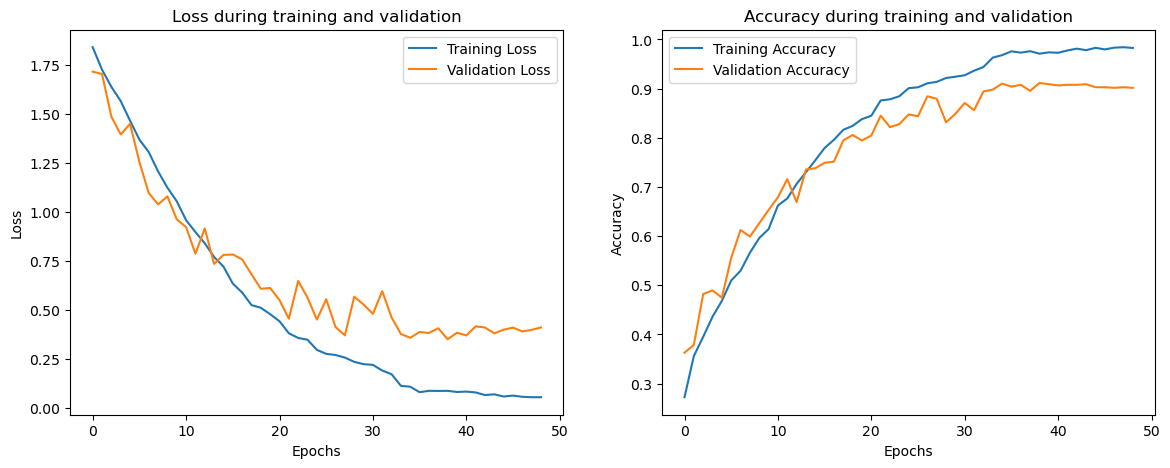

In [35]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(training_loss_resnet, label='Training Loss')
plt.plot(val_loss_resnet, label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_acc_resnet, label='Training Accuracy')
plt.plot(val_acc_resnet, label='Validation Accuracy')
plt.title('Accuracy during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:
import numpy as np
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size):
    """Load and preprocess an image for model prediction."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize if needed
    return img_array

def predict_image(model, img_path, target_size):
    """Predict the class of an image using the given model."""
    img_array = load_and_preprocess_image(img_path, target_size)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

# Example usage
img_path = '/Users/akshaya/Downloads/hel.jpeg.webp'  # Replace with your image path
target_size = (img_width, img_height)     # Ensure this matches your model's input size
predicted_class = predict_image(model, img_path, target_size)

# Decode predictions
class_labels = list(train_generator.class_indices.keys())
print(f"Predicted class: {class_labels[predicted_class[0]]}")


1/1 [==============================] - 0s 476ms/step
Predicted class: Swift
